# Exploring IEA Annual Electricity Generation by State Report
***

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format # display numbers as with thousands separator
pd.option_context('display.max_rows', None, 'display.max_columns', None)

from IPython.display import display, HTML
# Custom CSS to align DataFrame values to the right
css_rules = """
<style>
    table.dataframe th, table.dataframe td {
        text-align: right !important;
    }
</style>
"""
# Apply the custom CSS
display(HTML(css_rules))

# Save tables to a workbook
import openpyxl
wb = openpyxl.Workbook()
wb.save("Data/EIA/tables2.xlsx")


## Basic Data Exploration
***

In [37]:
renewables = ['hydroelectric conventional', 'wind', 'wood and wood derived fuels', 'other biomass', 'geothermal', 'solar thermal and photovoltaic']
fossils = ['coal', 'natural gas', 'petroleum', 'petroleum coke', 'other gases']
egen_df = pd.read_csv('Data/EIA/annual_generation_clean.csv')
print(f'There are {egen_df.shape[0]} rows and {egen_df.shape[1]} columns in the dataset')

There are 50938 rows and 5 columns in the dataset


In [38]:
egen_df.dtypes

year              int64
state            object
producerType     object
energySource     object
genMWH          float64
dtype: object

In [39]:
# Unique values for producers
producers = egen_df['producerType'].unique()
print("Unique values for producers: ")
print (*producers, sep=", ")

Unique values for producers: 
total, utilities, industrial_chp, commercial_chp, independent, electric_chp


In [40]:
# Unique values for energy sources
energy_sources = egen_df['energySource'].unique()
print("Unique values for energy sources: ")
print (*energy_sources, sep=", ")

Unique values for energy sources: 
coal, hydroelectric conventional, natural gas, petroleum, wind, wood and wood derived fuels, nuclear, other biomass, other gases, pumped storage, geothermal, other, solar thermal and photovoltaic


In [41]:
# Find the time range of the data
years = egen_df['year'].unique()
years.sort()
print(f'Data ranges from {years[0]} to {years[-1]}')

Data ranges from 1990 to 2022


## Look at characteristics of the data
<a class="anchor" id="look-at-characteristics-of-the-data"></a>
***

### First we'll just look at the aggregate generation by state and by year

In [42]:
tables = {}
# Find the amount of electricity produced each year
tables['yearly_total'] = egen_df.groupby('year')['genMWH'].sum().reset_index().rename(
    columns={"year": "Year", "genMWH": "MWh Generated"})

# Find the amount of electricity produced each year locality
tables['yearXstate'] = egen_df.groupby(['year', 'state'])['genMWH'].sum().reset_index().rename(
    columns={"year": "Year", "genMWH": "MWh Generated", 'state': 'State'})

### Then we'll look at:   
* summary statistics for the electricity generated by year and source   
* as well as summary statistics of generation by state and energy source.   

To do this we first need to aggregate electricity generation to be total generation of all producers in a state by year

In [43]:
# Create dataframe with aggregate generation (not from the different producer types)
total_gen = egen_df[egen_df['producerType'] == 'total']

aggregations = {'genMWH': ['min', 'max', 'median', 'sum']}
# Find the amount of electricity produced each year by fuel type
tables['yearXsource'] = total_gen.groupby(['year', 'energySource']).agg(aggregations).reset_index().rename(
    columns={"year": "Year", "genMWH": "MWh Generated", 'energySource': 'Energy Source'})

# Find the amount of electricity produced by fuel type and locality
tables['stateXsource'] = total_gen.groupby(['state', 'energySource']).agg(aggregations).reset_index().rename(
    columns={"genMWH": "MWh Generated", 'energySource': 'Energy Source', 'state': 'State'})


### Save all of these tables to an excel file for (hopefully) easier viewing

In [44]:
for name, table in tables.items():
    with pd.ExcelWriter("Data/EIA/tables2.xlsx", mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
        table.to_excel(writer, sheet_name=name, index=True)


## Start looking into time trends
***

### First we'll look at the trend of total generation per energy source

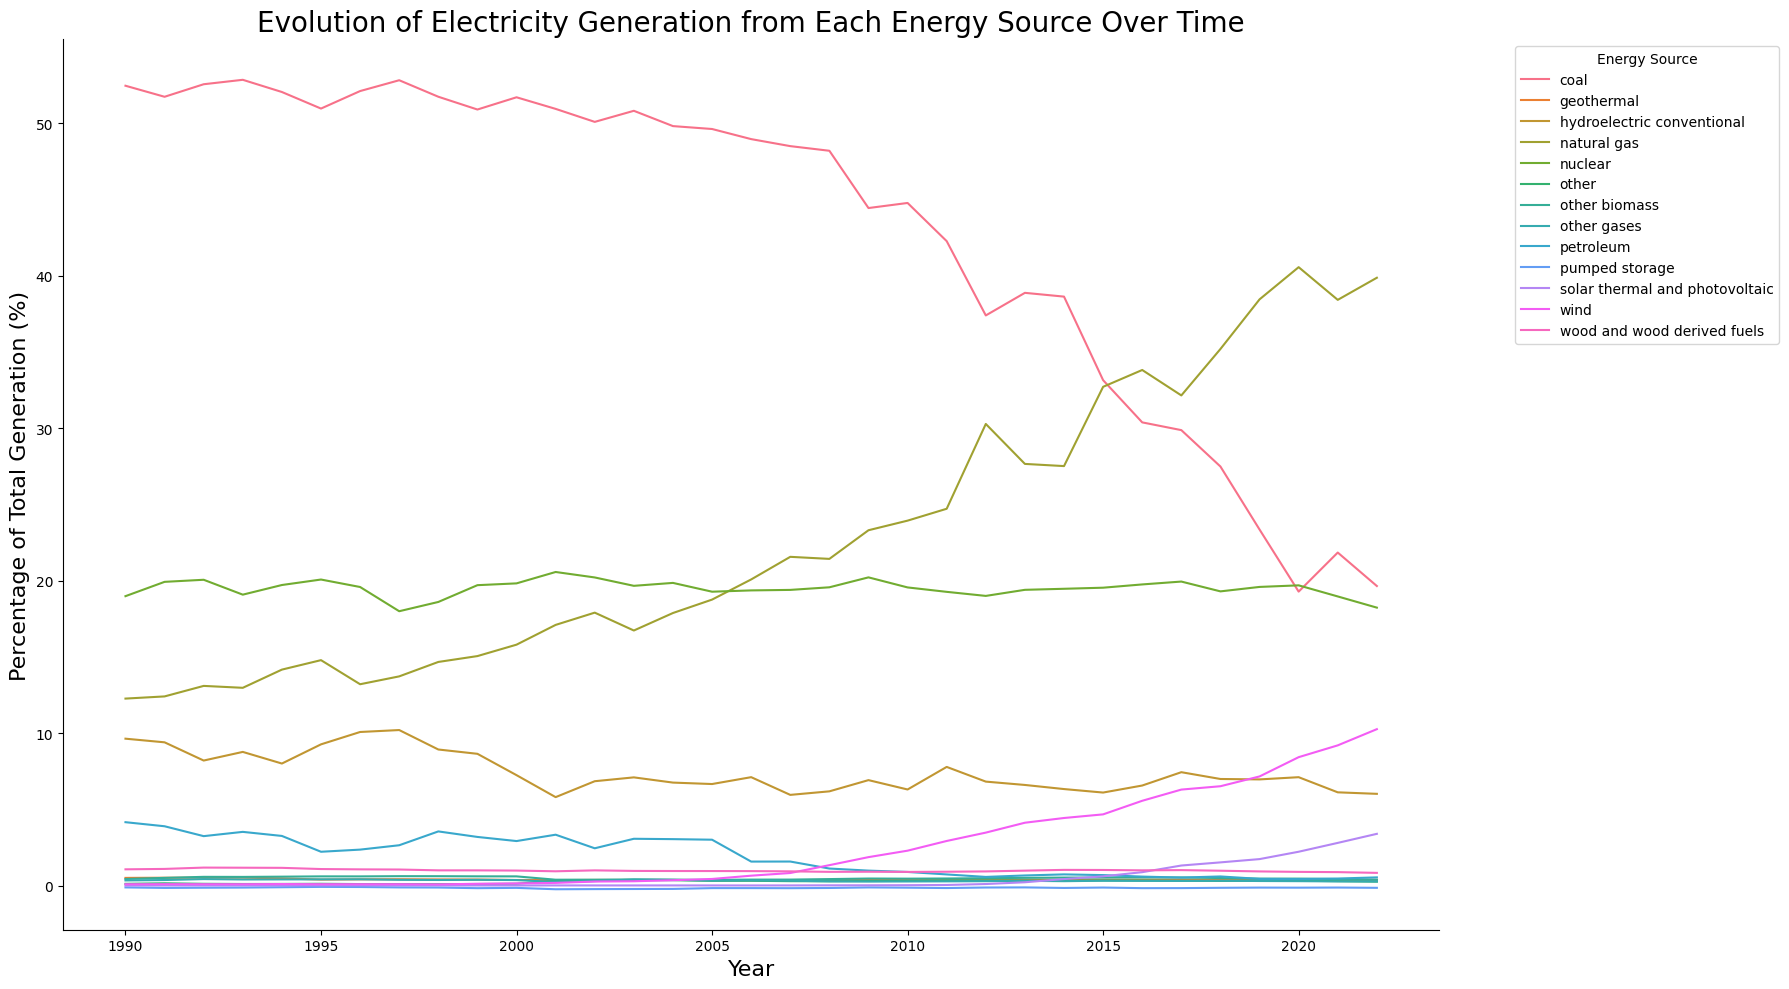

In [45]:
## Recall the total_gen dataframe is the total generation from all producer types for each state, source, and year

# group by year and energy source to get the total generation from each source for each year
grouped_data = total_gen.groupby(['year', 'energySource']).sum()['genMWH'].reset_index()

# Calculate the total energy generated each year
total_energy_per_year = grouped_data.groupby('year').sum()['genMWH']

# Calculate the percentage of total generation from each energy source
grouped_data['percentage'] = grouped_data.apply(lambda row: (row['genMWH'] / total_energy_per_year[row['year']]) * 100, axis=1)

# Time series visualization of the percentage of total generation from each energy source
plt.figure(figsize=(18, 10))
sns.lineplot(data=grouped_data, x='year', y='percentage', hue='energySource')
plt.title("Evolution of Electricity Generation from Each Energy Source Over Time", fontsize=20)
plt.ylabel("Percentage of Total Generation (%)", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.legend(title="Energy Source", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.despine() # Get rid of the box around the plot
plt.savefig('Visuals/pct_source_tot.png', dpi=300, bbox_inches='tight')
plt.show()

### That graph isn't very easy to read, so lets breakout the renewable sources into their own graph

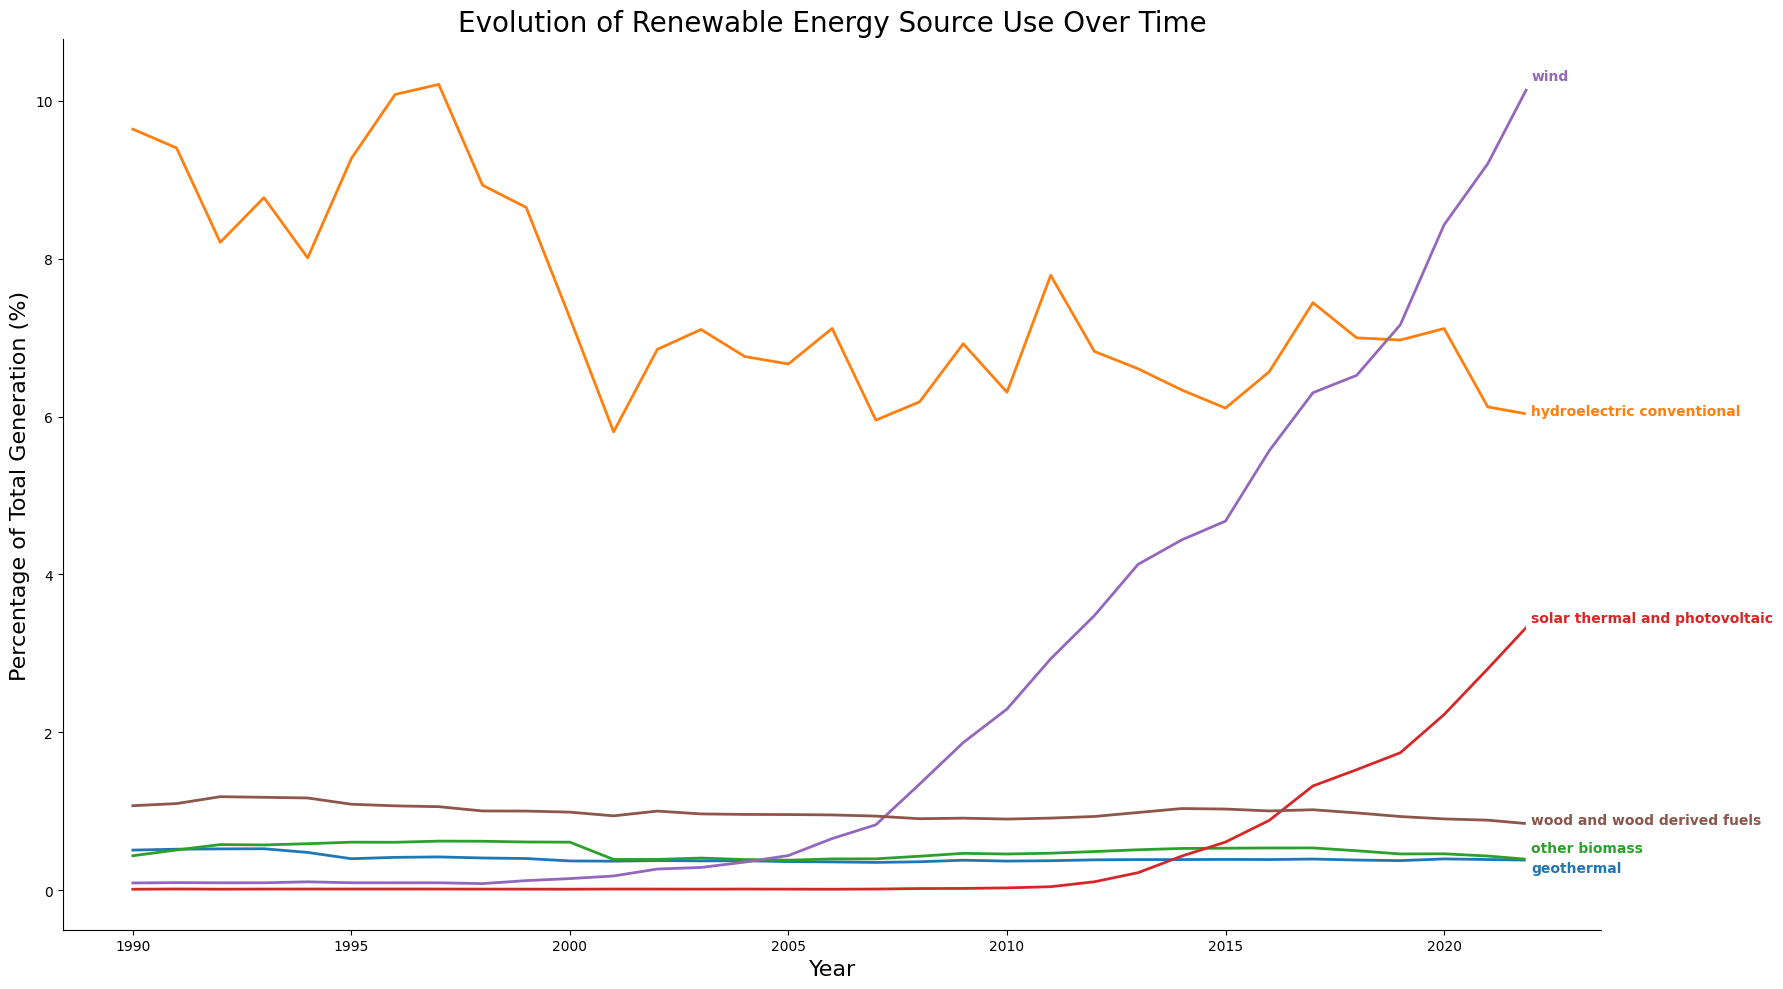

In [46]:
## Recall the grouped_data dataframe is the total generation from each source for each year with %'s from each sources

# Create a dataframe with only the renewable energy sources
renewables_data = grouped_data[grouped_data['energySource'].isin(renewables)]

# Time series visualization of the percentage of total generation from each renewable energy source
def label_line(ax, line, label, color, x_offset=0, y_offset=0):
    xdata = line.get_xdata()
    ydata = line.get_ydata()
    
    # Position to place the label at the end of each line
    x_pos = xdata[-1] + x_offset
    y_pos = ydata[-1] + y_offset
    
    ax.annotate(label,
                xy=(x_pos, y_pos),
                xytext=(x_pos, y_pos),
                weight='bold',
                color=color,
                backgroundcolor='white',
                fontsize=10)

# Plotting the time series visualization with labeled lines
plt.figure(figsize=(18, 10))
ax = sns.lineplot(data=renewables_data, x='year', y='percentage', hue='energySource', palette='tab10', lw=2)

# Remove the legend
ax.get_legend().remove()

# Labeling each line
for line, name in zip(ax.lines, renewables_data['energySource'].unique()):
    if name == "other biomass":
        y_offset = .1
    elif name == "geothermal":
        y_offset = -.15
    else: y_offset = 0
    label_line(ax, line, name, line.get_color(), y_offset=y_offset)

plt.title("Evolution of Renewable Energy Source Use Over Time", fontsize=20)
plt.ylabel("Percentage of Total Generation (%)", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.tight_layout()
sns.despine() # Get rid of the box around the plot
plt.savefig("Visuals/pct_renew_tot.png", dpi=300, bbox_inches='tight')
plt.show()


### At this point I want an animated scatter, but python is limited... So I'm going to do the data prep in python and then use R to make the animation
Each point on the scatterplot will represent a state, the y-axis will be pct renewable, the x-axis will by total production, and the animation will shift these points over the time period of the data

In [47]:
# Group data by year, state, and energy sourcer
state_source_df = total_gen.groupby(['year', 'state', 'energySource']).sum()['genMWH'].reset_index()

# Calculate the total energy generated each year by state
total_energy_by_state = state_source_df.groupby(['year', 'state']).sum()['genMWH']

# Calculate the percentage of total generation from each energy source
state_source_df['pct'] = state_source_df.apply(lambda row: (row['genMWH'] / total_energy_by_state.loc[row['year'], row['state']]) * 100, axis=1)

# Create a dataframe with only the renewable energy sources
renewables_data = state_source_df[state_source_df['energySource'].isin(renewables)]
renewables_df = renewables_data.groupby(['year', 'state']).agg({'pct': 'sum', 'genMWH': 'sum'}).reset_index()

# Create a dataframe with only the fossil fuel energy sources
fossils_data = state_source_df[state_source_df['energySource'].isin(fossils)]
fossils_df = fossils_data.groupby(['year', 'state']).agg({'pct': 'sum', 'genMWH': 'sum'}).reset_index()

# Add total energy generated by state
export_df = pd.merge(renewables_df, fossils_df, on=['year', 'state'], suffixes=('_renew', '_fossil'))
export_df = pd.merge(export_df, total_energy_by_state.reset_index(), on=['year', 'state'])

# Remove us-total
export_df = export_df[export_df['state'] != 'us-total']

# Export the data so I can use it in R
export_df.to_csv('Data/EIA/state_ren_pct.csv', index=False)

# Create table with summary statistics for each state
state_info = export_df[['state', 'pct_renew', 'genMWH_renew', 'pct_fossil', 'genMWH_fossil']].groupby(['state']).describe()
with pd.ExcelWriter("Data/EIA/tables2.xlsx", mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    state_info.to_excel(writer, sheet_name='state_info', index=True)

## Results from R animated scatterplot:
![SegmentLocal](Visuals\state_pct1.gif "segment")

## Also a line chart from R:
![SegmentLocal](Visuals\pct_ren_highlighted.png "segment")